# gymflow


For any business, a key challenge for growth of the business depends on not only identifying leads, but identifying leads with the highest protential closing value. For small businesses, this value obfuscated from the public for obvious reasons. For ClassPass, I would presume that are large majority of leads are these small businesses. However, this value can be inferred from other proxy measures that are publicly available. As for the businesses where this data does not exist, we can model these features for businesses where it does exist, and apply the model onto the business of interest. 

The goal of this project is to build a regression model to predict number of *Yelp* check-in's for a business given pubicly availabile attributes, namely its geographical location and business category. The intent is to use Yelp "check-in's" as a proxy for foot traffic.

The project is structured in three sections:


#### 1. Data Preparation and Analysis
    a. Data Wrangling, Munging, and Schema Assembly
            This work comprises the ETL required for building the Data Model. The downstream steps will
            carry the assumption that this data model is maintained upstream of the data prep pipeline and model pipeline.
    b. EDA
            This contains the exploratory data analysis to guide decisions surrounding data preparation, feature creation, and model selection.
    c. Data Preparation and Pipeline Creation
            Here I build the data prep pipeline required for model selection and training.

##### 2. Model Selection, Training, and Analysis
* All work related to selecting a model, optimizing hyperparameters, and analyzing performance

##### 3. Pipeline
* Creation of query tool and ML pipeline.

##### 4. Appendix 
* This section contains notes/ideas for future state, and some functions to explore additional data model robustness.

<br><br>
Author: Max Copeland (c) <br> Date: April 2021

In [448]:
import json
import os
from typing import List, Dict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pybea.client import BureauEconomicAnalysisClient
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, split, col, to_timestamp, count, month, year
from scipy import stats
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from yelpapi import YelpAPI


%matplotlib inline
sns.set()

In [83]:
# Instantiating spark session
spark = SparkSession.builder.getOrCreate()

# 1. Data Preparatioin and Analysis

## a. Data Wrangling, Munging, and Schema Assembly  

### Yelp Academic Dataset
Yelp published an [academic dataset](https://www.yelp.com/dataset) for any and all personal use. The aim of this project is to model check-in frequency as a function of category (i.e. what is the trend of check-ins for Barre studios?). The Check-In data will be the data workhorse, and additional dimensional data will be included for enrichment and additional feature generation.

In [84]:
# Reading yelp dataset of business listings
business_df = spark.read.option("inferSchema", "true").json("data/yelp_dataset/yelp_academic_dataset_business.json")

# Reading checkin dataset
checkin_df = spark.read.option("inferSchema", "true").json("data/yelp_dataset/yelp_academic_dataset_checkin.json")
# Splitting up "date" string field into array, delimited on commas
checkin_df = checkin_df.withColumn('date', split(col('date'), ', ').cast('array<string>'))


In [85]:
# Reading schema for the yelp business listsings
business_df.printSchema()

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

In [86]:
# Reading schema for the yelp check-in data
checkin_df.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- date: array (nullable = true)
 |    |-- element: string (containsNull = true)



Creating view into spark session for downstream SQL functionality.

In [87]:
business_df.createOrReplaceTempView("businesses")
checkin_df.createOrReplaceTempView("checkins")

Filtering down `business_df` for categories pertinent to ClassPass. These criteria were derived from the "search" portal within the ClassPass app, collecting tags associated with businesses.

In [88]:
classpass_cond = (
            (
                business_df.categories.contains("Gym") | \
            business_df.categories.contains("Fitness") | \
            business_df.categories.contains("Wellness") | \
            business_df.categories.contains("Yoga") | \
            business_df.categories.contains("Spa") | \
            business_df.categories.contains("Sports") | \
            business_df.categories.contains("Cycling") | \
            business_df.categories.contains("Boxing") | \
            business_df.categories.contains("Recreation")    
            ) 
                  & 
            (
            ~business_df.categories.contains("Bars") & \
            ~business_df.categories.contains("Restaurant") & \
            ~business_df.categories.contains("Shopping")
            )
        
        )

classpass_df = business_df.where(classpass_cond)
classpass_df.createOrReplaceTempView("classpass_businesses")

Joining `checkin_df` against the filtered `business_df`. Resulting table will have the same number of entries as `business_df`, but with and an additional field containing an array of all checkins. 

In [89]:
classpass_checkin_df = checkin_df.join(classpass_df, on="business_id", how='inner')

classpass_checkin_df = classpass_checkin_df.withColumn('categories', split(col('categories'), ', ').astype('array<string>'))

## Exploding out checkin data to have singular category vector

To have a more trainable model downstream, it is important that I scaffold out the current dataset to contain a record for every unique pairing of category and check-in timestamp for each associated with a business. 

In this format, we can run an aggregation to bin number of check-in's by some time-interval (likely year).

In [90]:
# Reminding myself of the schema for our current dataset
classpass_checkin_df.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- date: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = tru

In [91]:
# Scaffolding out check-in array field into a record for every check-in timestamp per business
checkin_df_exploded = classpass_checkin_df.select("business_id", "categories", explode(col("date")).alias("date")).withColumn("date", to_timestamp("date"))

# Further scaffolding out categories array field into a record for every distint category per business
checkin_df_exploded = checkin_df_exploded.select("business_id", "date", explode(col("categories")).alias("category"))

In [92]:
checkin_df_exploded.show()

+--------------------+-------------------+-------------------+
|         business_id|               date|           category|
+--------------------+-------------------+-------------------+
|--8LPVSo5i0Oo61X0...|2016-07-08 16:43:30|Weight Loss Centers|
|--8LPVSo5i0Oo61X0...|2016-07-08 16:43:30|            Doctors|
|--8LPVSo5i0Oo61X0...|2016-07-08 16:43:30|    Sports Medicine|
|--8LPVSo5i0Oo61X0...|2016-07-08 16:43:30|       Orthopedists|
|--8LPVSo5i0Oo61X0...|2016-07-08 16:43:30|   Health & Medical|
|--9QQLMTbFzLJ_oT-...|2010-06-26 17:39:07|        Hair Salons|
|--9QQLMTbFzLJ_oT-...|2010-06-26 17:39:07|      Beauty & Spas|
|--9QQLMTbFzLJ_oT-...|2010-08-01 20:06:21|        Hair Salons|
|--9QQLMTbFzLJ_oT-...|2010-08-01 20:06:21|      Beauty & Spas|
|--9QQLMTbFzLJ_oT-...|2010-12-09 21:21:24|        Hair Salons|
|--9QQLMTbFzLJ_oT-...|2010-12-09 21:21:24|      Beauty & Spas|
|--9QQLMTbFzLJ_oT-...|2011-08-12 00:42:57|        Hair Salons|
|--9QQLMTbFzLJ_oT-...|2011-08-12 00:42:57|      Beauty 

In this format, we can now run an aggregation to count the number of check-in's per business per category.

In [93]:
checkin_df_yearly = checkin_df_exploded.groupBy("business_id", "category", year("date").alias("year")).count()

# Adding table to the data model
checkin_df_yearly.createOrReplaceTempView("checkin_count_yr")

Confirming SQL functionality on new table...

In [94]:
spark.sql("SELECT * FROM checkin_count_yr ORDER BY business_id, year").show()

+--------------------+-------------------+----+-----+
|         business_id|           category|year|count|
+--------------------+-------------------+----+-----+
|--8LPVSo5i0Oo61X0...|       Orthopedists|2016|    1|
|--8LPVSo5i0Oo61X0...|   Health & Medical|2016|    1|
|--8LPVSo5i0Oo61X0...|            Doctors|2016|    1|
|--8LPVSo5i0Oo61X0...|    Sports Medicine|2016|    1|
|--8LPVSo5i0Oo61X0...|Weight Loss Centers|2016|    1|
|--9QQLMTbFzLJ_oT-...|      Beauty & Spas|2010|    3|
|--9QQLMTbFzLJ_oT-...|        Hair Salons|2010|    3|
|--9QQLMTbFzLJ_oT-...|      Beauty & Spas|2011|    3|
|--9QQLMTbFzLJ_oT-...|        Hair Salons|2011|    3|
|--9QQLMTbFzLJ_oT-...|        Hair Salons|2012|    2|
|--9QQLMTbFzLJ_oT-...|      Beauty & Spas|2012|    2|
|--9QQLMTbFzLJ_oT-...|      Beauty & Spas|2013|    8|
|--9QQLMTbFzLJ_oT-...|        Hair Salons|2013|    8|
|--9QQLMTbFzLJ_oT-...|        Hair Salons|2014|    8|
|--9QQLMTbFzLJ_oT-...|      Beauty & Spas|2014|    8|
|--9QQLMTbFzLJ_oT-...|      

In [95]:
spark.sql("""
            SELECT biz.postal_code, chk.category, chk.year, chk.count
            FROM classpass_businesses biz
            INNER JOIN checkin_count_yr chk
                ON biz.business_id = chk.business_id
         """
         ).show()

+-----------+--------------------+----+-----+
|postal_code|            category|year|count|
+-----------+--------------------+----+-----+
|      85283|       Beauty & Spas|2018|    3|
|      89147|        Hair Removal|2019|   25|
|      85259|            Day Spas|2015|    1|
|      85032|     Sports Medicine|2013|    6|
|      89102|         Hair Salons|2018|    4|
|      89103|           Skin Care|2017|    3|
|      85297|         Hair Salons|2019|    3|
|      61820|       Beauty & Spas|2016|    1|
|      89102|       Beauty & Spas|2014|   10|
|      89012|         Nail Salons|2015|   11|
|      15206|       Beauty & Spas|2019|    1|
|      89052|         Active Life|2018|    1|
|      89178|         Active Life|2014|   23|
|      28078|Venues & Event Sp...|2012|    5|
|    J5B 1H1|         Active Life|2017|    1|
|      85282|    Health & Medical|2014|    2|
|      89117|         Nail Salons|2018|   20|
|    L5N 2W7|                Gyms|2013|    5|
|    T2S 0A5|     Eyelash Service|

### Parsing City Data

There are two datasets of interest for regional data: one with information on all US cities, and a dataset of population estimates for each US county from 2010-2019. 

In [96]:
CITIES_FILEPATH = os.path.join("data", "uscities.csv")
COUNTY_POPULATIONS_FILEPATH = os.path.join("data", "co-est2019-alldata.csv")


First, I need to write a function to read the files and merge them.

In [97]:
def get_cities_df(cities_filepath, population_filepath, limit=None):
    """
    Returns dataframe of city-level attributes for all US cities. 
    
    """
    city_df = pd.read_csv(cities_filepath).sort_values("population", ascending=False)
    city_df['city_st'] = city_df['city_ascii'] + ", " + city_df['state_id']

    if limit is not None:
        city_df = city_df.iloc[:limit, :]
        
    pop_df = pd.read_csv(population_filepath)
    
    pop_df = pop_df[pop_df['CTYNAME'].str.contains('County')]
    pop_df['CTYNAME'] = pop_df['CTYNAME'].apply(lambda x: x.split(' County')[0])
    
    full_df = pd.merge(city_df, pop_df, left_on=['county_name', 'state_name'], right_on=['CTYNAME', 'STNAME'])
    
    return full_df.reset_index()

    


Reading in datafiles...

In [98]:
cities_pd_df = get_cities_df(CITIES_FILEPATH, COUNTY_POPULATIONS_FILEPATH)

In [99]:
cities_pd_df.head()

,index,city,city_ascii,state_id,state_name,county_fips,county_name,lat,lng,population,...,RDOMESTICMIG2019,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,RNETMIG2016,RNETMIG2017,RNETMIG2018,RNETMIG2019
0,0,New York,New York,NY,New York,36061,New York,40.6943,-73.9249,18713220,...,-7.201265,6.150025,3.585789,-3.412067,-3.133048,-1.605270,-4.965909,-7.488348,-4.535926,-3.071435
1,1,Manhattan,Manhattan,NY,New York,36061,New York,40.7834,-73.9662,1628706,...,-7.201265,6.150025,3.585789,-3.412067,-3.133048,-1.605270,-4.965909,-7.488348,-4.535926,-3.071435
2,2,Los Angeles,Los Angeles,CA,California,6037,Los Angeles,34.1139,-118.4068,12750807,...,-10.024157,-2.160639,-1.102370,-1.268074,-2.306246,-2.202978,-3.985415,-5.864988,-7.670182,-7.930985
3,3,Long Beach,Long Beach,CA,California,6037,Los Angeles,33.7981,-118.1675,462628,...,-10.024157,-2.160639,-1.102370,-1.268074,-2.306246,-2.202978,-3.985415,-5.864988,-7.670182,-7.930985
4,4,Lancaster,Lancaster,CA,California,6037,Los Angeles,34.6935,-118.1753,343304,...,-10.024157,-2.160639,-1.102370,-1.268074,-2.306246,-2.202978,-3.985415,-5.864988,-7.670182,-7.930985


Unfortunately, the county population data format won't be usable for training. These attributes are housed in separate fields for each year they were recorded. The format we need needs to have single field for the metric, and be broken out by the year of recording.

In [100]:
# These are the prefixes of interest from the county data 
feats = ['POPESTIMATE',
 'NPOPCHG_',
 'BIRTHS',
 'DEATHS',
]

# By convention, the city data has lower-case fieldnames by design, and 
# county data has upper-case fieldnames by design. Thus I can run a boolean index
# based on case to delineate dimensions and measures.
dimensions = cities_pd_df.columns[~cities_pd_df.columns.str.isupper()]
measures = cities_pd_df.columns[cities_pd_df.columns.str.isupper()]

The below functions reformat the county population data such that each population measure is broken out by year.

In [101]:
def get_cols(df, prefix):
    """
    Runs a search on column names based on given prefix and returns a list of matches
    """
    return list(df.columns[[(prefix == x[:-4]) for x in df.columns]].values)


def format_cities_df(df, feats):
    """
    Reformats county data to contain a field for each type of measure, 
    broken out by year. 
    """
    
    full_df = None
    
    for feat in feats:
        
        # Get the columns that have the given prefix 
        cols = get_cols(df, feat)
        
        # Getting identifier dimensions plus the retrieved columns for the measure of interest
        data = df[['city', 'state_name', 'zips', 'lat', 'lng'] + cols]
        
        # Breaking out down to have a single column for the measure, with a record for each year it was recorded
        melted = pd.melt(data, id_vars=['city', 'state_name', 'zips', 'lat', 'lng'], value_vars=cols, value_name=feat, var_name='year')
        
        # Parsing the year from the feature name
        melted['year'] = melted['year'].apply(lambda x:x[-4:])

        # Iteratively merging data for each feature into a single dataframe
        if full_df is None:
            full_df = melted
        
        else:
            full_df = pd.merge(full_df, melted, how='left', left_on=['city', 'state_name', 'year', 'zips', 'lat', 'lng'], 
                               right_on=['city', 'state_name', 'year', 'zips', 'lat', 'lng'])

    
    return full_df

In [102]:
cities_pd_df

,index,city,city_ascii,state_id,state_name,county_fips,county_name,lat,lng,population,...,RDOMESTICMIG2019,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,RNETMIG2016,RNETMIG2017,RNETMIG2018,RNETMIG2019
0,0,New York,New York,NY,New York,36061,New York,40.6943,-73.9249,18713220,...,-7.201265,6.150025,3.585789,-3.412067,-3.133048,-1.605270,-4.965909,-7.488348,-4.535926,-3.071435
1,1,Manhattan,Manhattan,NY,New York,36061,New York,40.7834,-73.9662,1628706,...,-7.201265,6.150025,3.585789,-3.412067,-3.133048,-1.605270,-4.965909,-7.488348,-4.535926,-3.071435
2,2,Los Angeles,Los Angeles,CA,California,6037,Los Angeles,34.1139,-118.4068,12750807,...,-10.024157,-2.160639,-1.102370,-1.268074,-2.306246,-2.202978,-3.985415,-5.864988,-7.670182,-7.930985
3,3,Long Beach,Long Beach,CA,California,6037,Los Angeles,33.7981,-118.1675,462628,...,-10.024157,-2.160639,-1.102370,-1.268074,-2.306246,-2.202978,-3.985415,-5.864988,-7.670182,-7.930985
4,4,Lancaster,Lancaster,CA,California,6037,Los Angeles,34.6935,-118.1753,343304,...,-10.024157,-2.160639,-1.102370,-1.268074,-2.306246,-2.202978,-3.985415,-5.864988,-7.670182,-7.930985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27229,27229,Brewster,Brewster,NE,Nebraska,31009,Blaine,41.9384,-99.8651,17,...,-31.746032,-16.789087,49.331963,-55.785124,39.583333,-31.023785,-29.567054,21.074816,-10.427529,-31.746032
27230,27230,Tryon,Tryon,NE,Nebraska,31117,McPherson,41.5584,-100.9536,92,...,4.065041,27.522936,-83.018868,36.644166,-38.535645,-44.044044,34.274194,-14.056225,-2.034588,4.065041
27231,27231,Harrisburg,Harrisburg,NE,Nebraska,31007,Banner,41.5505,-103.7266,88,...,20.408163,-49.034175,34.353996,-16.152717,-7.418398,62.273715,-2.803083,11.095700,-13.783598,20.408163
27232,27232,Charles City,Charles City,VA,Virginia,51036,Charles City,37.3441,-77.0687,60,...,0.429707,-2.350664,-9.071244,-3.521623,-12.384342,6.988021,2.272727,4.551920,-0.285185,0.572943


Reformatting data with above function...

In [103]:
formatted_cities_df_pd = format_cities_df(cities_pd_df, feats)
formatted_cities_df_pd.head()

,city,state_name,zips,lat,lng,year,POPESTIMATE,NPOPCHG_,BIRTHS,DEATHS
0,New York,New York,11229 11226 11225 11224 11222 11221 11220 1138...,40.6943,-73.9249,2010,1588767,2386,5028,2290
1,Manhattan,New York,10026 10027 10030 10037 10039 10001 10011 1001...,40.7834,-73.9662,2010,1588767,2386,5028,2290
2,Los Angeles,California,90291 90293 90292 91316 91311 90037 90031 9000...,34.1139,-118.4068,2010,9823246,3278,31738,13803
3,Long Beach,California,90822 90804 90805 90806 90807 90802 90803 9080...,33.7981,-118.1675,2010,9823246,3278,31738,13803
4,Lancaster,California,93535 93534 93536 93539 93584,34.6935,-118.1753,2010,9823246,3278,31738,13803


Converting output data into spark dataframe for integration with our data model.

In [104]:
formatted_cities_df = spark.createDataFrame(formatted_cities_df_pd)

# Scaffolding out zip code array to have a record for each distinct zip. 
# This is important as the zip code will be our key with which we we'll run 
# downstream joins.
formatted_cities_df = formatted_cities_df.withColumn("zip", explode(split(col("zips"), "\s+")))

In [105]:
# Adding reformatted data as a table in our data model.
formatted_cities_df.createOrReplaceTempView("populations")

In [106]:
spark.sql("SHOW tables").show()

+--------+--------------------+-----------+
|database|           tableName|isTemporary|
+--------+--------------------+-----------+
|        |          businesses|       true|
|        |    checkin_count_yr|       true|
|        |            checkins|       true|
|        |classpass_businesses|       true|
|        |         populations|       true|
+--------+--------------------+-----------+



In [610]:
df_spark = spark.sql("""
                            SELECT biz.latitude, biz.longitude, biz.stars, biz.review_count, pop.POPESTIMATE as population,
                                    chk.category, chk.year, chk.count as label
                            FROM checkin_count_yr chk
                            LEFT JOIN classpass_businesses biz
                                ON chk.business_id = biz.business_id
                            LEFT JOIN populations pop
                                 ON biz.postal_code = pop.zip AND chk.year = pop.year
                            WHERE pop.POPESTIMATE IS NOT NULL
                          """)

In [611]:
df_spark.show()

+-------------+--------------+-----+------------+----------+--------------------+----+-----+
|     latitude|     longitude|stars|review_count|population|            category|year|label|
+-------------+--------------+-----+------------+----------+--------------------+----+-----+
|   40.4275224|   -79.9679844|  3.5|          26|   1233027|        Hair Removal|2014|    1|
|   40.4275224|   -79.9679844|  3.5|          26|   1233027|       Beauty & Spas|2014|    1|
|   40.4275224|   -79.9679844|  3.5|          26|   1233027|    Ophthalmologists|2014|    1|
|   40.4275224|   -79.9679844|  3.5|          26|   1233027|   Cosmetic Surgeons|2014|    1|
|   40.4275224|   -79.9679844|  3.5|          26|   1233027|  Laser Hair Removal|2014|    1|
|   40.4275224|   -79.9679844|  3.5|          26|   1233027|             Doctors|2014|    1|
|   40.4275224|   -79.9679844|  3.5|          26|   1233027|        Optometrists|2014|    1|
|   40.4275224|   -79.9679844|  3.5|          26|   1233027|    Health

## b. EDA

Here I'll explore the distributions and correlations between variables, as well as identify any problematic outliers.

In [612]:
df = df_spark.toPandas()

In [579]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450550 entries, 0 to 450549
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   latitude      450550 non-null  float64
 1   longitude     450550 non-null  float64
 2   stars         450550 non-null  float64
 3   review_count  450550 non-null  int64  
 4   postal_code   450550 non-null  object 
 5   population    450550 non-null  int64  
 6   category      450550 non-null  object 
 7   year          450550 non-null  int32  
 8   label         450550 non-null  int64  
dtypes: float64(3), int32(1), int64(3), object(2)
memory usage: 29.2+ MB


Luckily no nulls in our data, which was by design in our data model construction.

In [580]:
df.describe()

,latitude,longitude,stars,review_count,population,year,label
count,450550.000000,450550.000000,450550.000000,450550.000000,4.505500e+05,450550.000000,450550.000000
mean,36.250443,-103.254031,3.963689,48.006681,2.434779e+06,2015.346372,23.885484
std,2.961348,14.912698,0.811950,102.377777,1.420107e+06,2.556731,101.153244
min,33.215156,-115.366722,1.000000,3.000000,1.850000e+04,2010.000000,1.000000
25%,33.587957,-115.117904,3.500000,9.000000,1.233700e+06,2013.000000,2.000000
50%,36.033257,-111.931770,4.000000,22.000000,2.138836e+06,2016.000000,4.000000
75%,36.215546,-81.658105,4.500000,51.000000,4.093648e+06,2018.000000,13.000000
max,43.250923,-79.651157,5.000000,2746.000000,1.010371e+07,2019.000000,3918.000000


Scrutinizing above, it appears we have some outliers that may need to be dropped. Namely in `review_count` and `label`. Note the quartiles. Both fields have max values several orders of magnitude greater than the 75th percentile.

To reconcile I'll take z-scores for these columns and create a boolean mask to exclude values above the threshold. 

In [581]:
z_reviews = np.abs(stats.zscore(df['review_count']))
z_labels = np.abs(stats.zscore(df['label']))

z_threshold = 2.8 # This corresponds to the highest 0.2% of the distribution 

outlier_mask = ((z_reviews < z_threshold) & (z_labels < z_threshold))

df = df[outlier_mask]

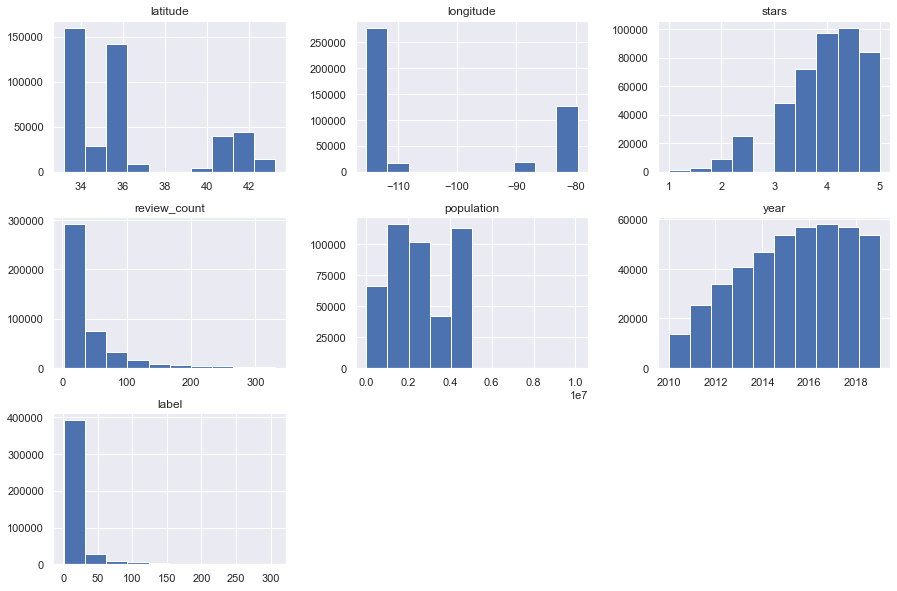

In [582]:
df.hist(figsize=(15, 10));

Creating correlation matrix to identifying covarying features.

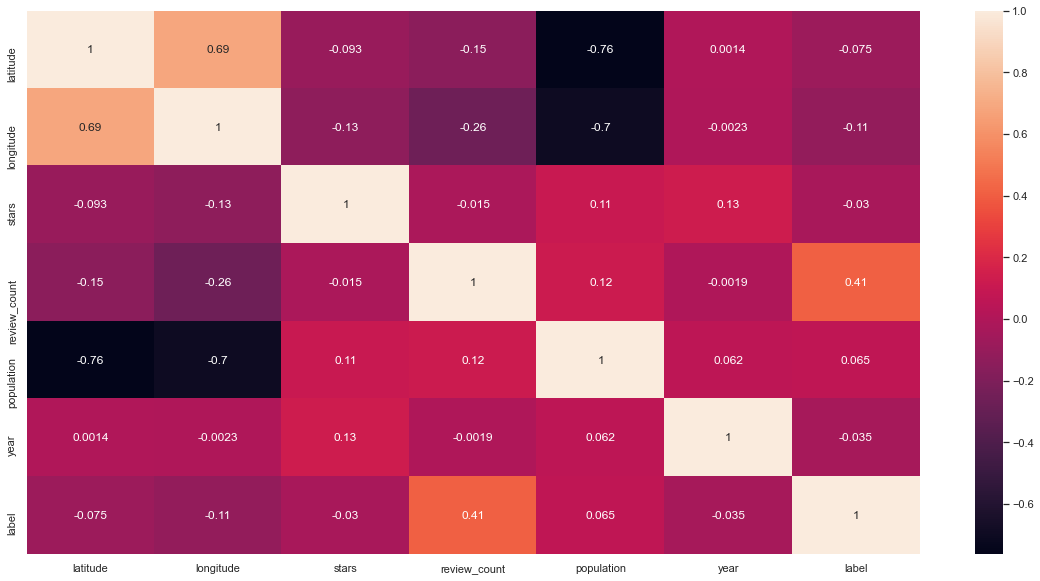

In [583]:
corr_mat = df.corr(method='pearson')
plt.figure(figsize=(20, 10))
sns.heatmap(corr_mat, annot=True);

An interesting covariance is between population and longitude/latitude. Similarly a positive correlation with longitude and latitude. 

In [646]:
# List comprehension to get all categories and their counts
category_counts = df.category.value_counts()

Analyzing highest checked-in business categories and their distributions...

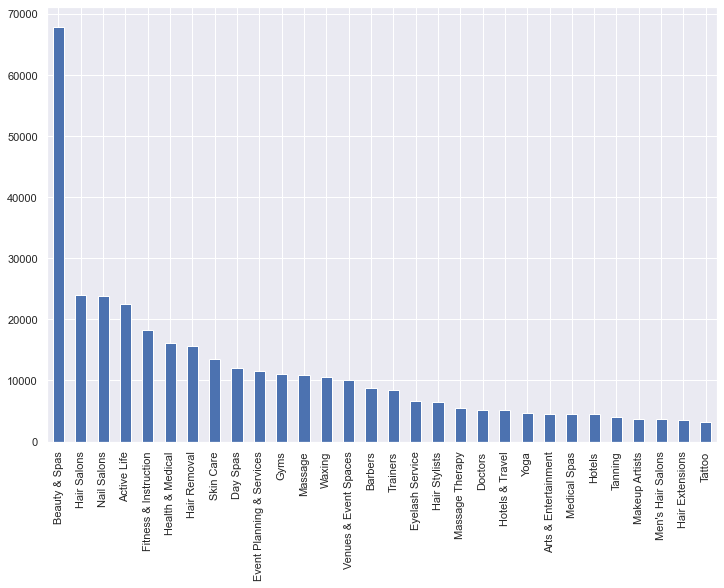

In [647]:
fig, ax = plt.subplots(figsize=(12, 8))

category_counts[:30].plot(kind='bar', ax=ax);

Here, we have a set of businesses has an associated set of categories. For the purposes of this analysis, we are not interested in business-level data, nor are we are interested in category-set-level data-- we are interested in data at the singular-category level. 

To achieve this, we must aggregate and union checkins across businesses.

In [648]:
target_categories = category_counts.index.values[:30]

# Dict where k:v is <category>:<checkin_array>
checkins = {cat:[] for cat in target_categories}

# Loop through list of lists, and extend checkin array in the checkins dict
for cat_list, checkin_array in zip(classpass_checkin_pd_df.categories, classpass_checkin_pd_df.date):
    for cat in cat_list:
        if cat in target_categories:
            checkins[cat].extend(checkin_array)

In [649]:
# Casting arrays to datetime objects
for cat, checkin_arr in checkins.items():
    checkins[cat] = pd.to_datetime(checkin_arr).sort_values()


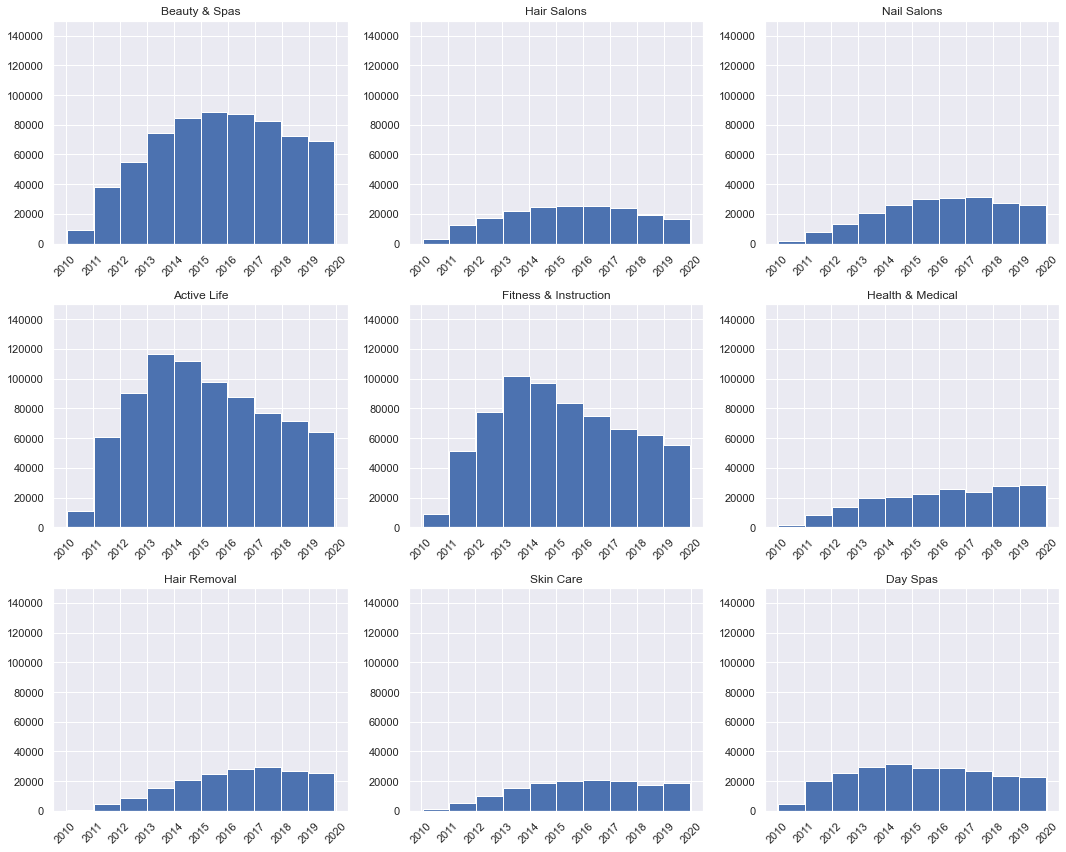

In [650]:
# Building out charts on handful of categories validate the upstream checkin aggregation

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(15, 12))


axes = (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9)


for ax, cat in zip(axes, category_counts.index.values[:len(axes)]):
    ax.hist(checkins[cat])
    ax.set_title(cat)
    ax.tick_params(axis='x', labelrotation=45)
    ax.set_ylim((0, 150000))

plt.tight_layout()


Generating a Cumulative Distribution Function of our category frequencies. For training, it makes sense to limit the number of categories to those with a higher volume of data points.

In [651]:
# Getting ordered bins of frequency
freq = df['category'].value_counts().values

# Calculating cdf
cdf = np.cumsum(freq) / np.sum(freq)

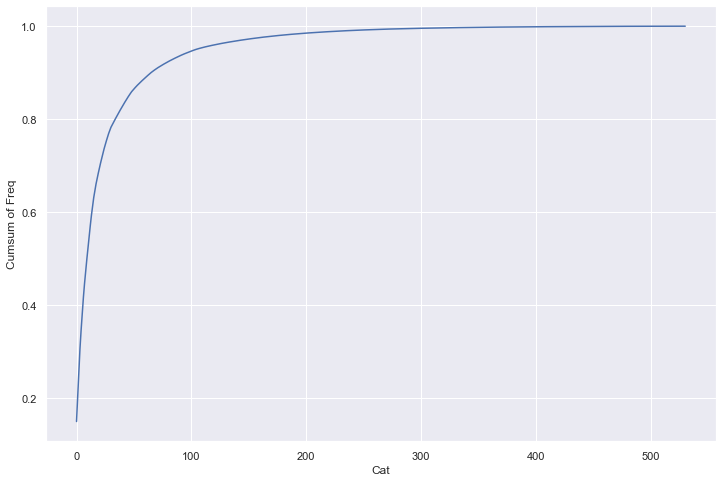

In [652]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(cdf)
ax.set_ylabel('Cumsum of Freq')
ax.set_xlabel('Cat');

For a RandomForest model, the more categories in our training data, the more complicated the model will be. If we can limit the numbers of bins of categories, we can avoid overfitting.

Based on our CDF, the first 50 categories captures ~85% of the data. We will limit our training data to these instances.

## c. Data Prep

I plan to use a tree-based model, which helps us avoid the scaling/encoding steps necessary for linear models.

One necessary preprocessing step is to create a custom encoding of categories, as tree models require a numeric value.  Rather than using ordinal encoding, I'll make this encoded value to be a function of the number of occurrences in the training data. To avoid collisions, I will add a high precision randomly generated number on (0, 1). 

In [653]:
def encode_categories(categories_col, return_map=False):
    
    cat_counts = categories_col.value_counts()
    
    encoding_map = {k:v + np.random.random() for k, v in zip(cat_counts.index, cat_counts.values)}
    
    if return_map:
        return categories_col.map(encoding_map), encoding_map
    
    return categories_col.map(encoding_map)

In [654]:
prep_df = df.copy()
prep_df['category']  = encode_categories(prep_df['category'])

Now we'll split up training and test data for model training and evaluation.

In [655]:
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(df, labels)

labels = prep_df['label']
prep_df = prep_df.drop(columns=['label'])
X_train, X_test, y_train, y_test = train_test_split(prep_df, labels)

# Model Training

Based on non-linearity of our encoded category variable, Random Forest is an obvious first-choice for a regressor. 
The features we will train on will be latitude, longitude, review_count, stars, population, and the search term (category). 

Note: Being that this project is being run locally, I will train the regressor strictly in sklearn, rather than spark, to avoid configuration of memory allocation to local workers. In a production environment (via EMR or the like) Spark would be the ideal framework.

From here we're at a good place to begin training. Rather than splitting up training and test data, I'll run a cross-validator on a grid of hyperparameters to find best estimator.

In [656]:
grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6]},
#     {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

reg = RandomForestRegressor()

grid_search = GridSearchCV(reg, grid, cv=5, scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(prep_df, labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6],
                          'n_estimators': [3, 10, 30]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [657]:
cv_results = grid_search.cv_results_
for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
    print(np.sqrt(-mean_score), params)

58.29424821903359 {'max_features': 2, 'n_estimators': 3}
50.84074063162543 {'max_features': 2, 'n_estimators': 10}
48.371337300851515 {'max_features': 2, 'n_estimators': 30}
55.249993159332035 {'max_features': 4, 'n_estimators': 3}
51.24414472743114 {'max_features': 4, 'n_estimators': 10}
49.79096544559174 {'max_features': 4, 'n_estimators': 30}
56.11767558417299 {'max_features': 6, 'n_estimators': 3}
52.816603872779794 {'max_features': 6, 'n_estimators': 10}
51.7342838187755 {'max_features': 6, 'n_estimators': 30}


In [658]:
grid_search.best_estimator_

RandomForestRegressor(max_features=2, n_estimators=30)

In [659]:
grid_search.best_params_

{'max_features': 2, 'n_estimators': 30}

Training model with best params.

In [660]:
final_reg = RandomForestRegressor(max_features=4, n_estimators=30)

final_reg.fit(X_train, y_train)

RandomForestRegressor(max_features=4, n_estimators=30)

In [661]:
y_pred = final_reg.predict(X_test)
final_rmse = np.sqrt(mean_squared_error(y_pred, y_test))

Analyzing 95% confidence interval for RMSE

In [662]:
from scipy import stats
 
conf = 0.95

squared_e = (y_pred - y_test) ** 2
conf_int_95 = np.sqrt(stats.t.interval(conf, len(squared_e) - 1, loc=squared_e.mean(), scale=stats.sem(squared_e)))

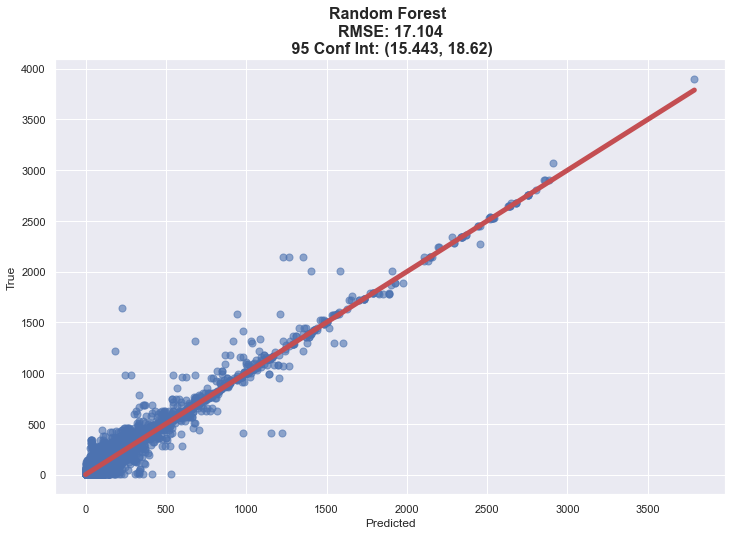

In [664]:
plt.figure(figsize=(12, 8))

x = np.arange(y_pred.max())

plt.scatter(y_pred, y_test, alpha=0.6, s=50, label="model")
plt.plot(x, x, lw=5, color='r', label='theoretical')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Random Forest \nRMSE: {round(final_rmse,3)}\n 95 Conf Int: {round(conf_int_95[0], 3), round(conf_int_95[1], 2)}", 
          size=16, weight='bold');

In [199]:
cv_results_df = pd.DataFrame(grid_search.cv_results_)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.172808,0.053689,0.098618,0.006860,2,3,"{'max_features': 2, 'n_estimators': 3}",-1022.075298,-936.025229,-1108.047112,...,-1064.879389,95.406239,9,-267.426861,-297.959022,-304.175302,-313.708173,-294.168010,-295.487474,15.509480
1,3.869822,0.051967,0.299388,0.017014,2,10,"{'max_features': 2, 'n_estimators': 10}",-734.057793,-634.218763,-733.232096,...,-728.077190,55.738655,6,-146.699037,-132.377225,-147.205394,-157.131734,-152.512230,-147.185124,8.328549
2,11.324354,0.341714,0.874944,0.029368,2,30,"{'max_features': 2, 'n_estimators': 30}",-695.855293,-552.080710,-566.803314,...,-615.229330,52.298496,3,-99.012573,-95.732752,-97.267988,-101.433954,-94.430989,-97.575651,2.462969
3,1.849018,0.078280,0.083294,0.001023,4,3,"{'max_features': 4, 'n_estimators': 3}",-937.880354,-762.769557,-727.504147,...,-846.479248,84.514119,7,-251.094385,-237.079966,-235.544011,-247.499729,-246.663392,-243.576297,6.134575
4,5.657529,0.039672,0.272307,0.003962,4,10,"{'max_features': 4, 'n_estimators': 10}",-552.876036,-493.694390,-452.110819,...,-519.535519,41.589489,2,-108.874416,-107.464119,-99.282168,-111.531265,-104.831915,-106.396777,4.164309
5,17.576453,0.632457,0.858133,0.041449,4,30,"{'max_features': 4, 'n_estimators': 30}",-533.208822,-417.081780,-447.413266,...,-476.103292,40.520317,1,-78.726066,-79.352511,-77.864259,-81.315563,-76.577671,-78.767214,1.577832
6,2.906007,0.155949,0.084682,0.003525,6,3,"{'max_features': 6, 'n_estimators': 3}",-726.427999,-747.835444,-841.178878,...,-868.537424,129.719088,8,-213.907937,-255.766673,-233.479003,-255.453024,-223.138040,-236.348935,16.901937
7,9.362352,0.266457,0.278847,0.004849,6,10,"{'max_features': 6, 'n_estimators': 10}",-617.430724,-594.981626,-604.907348,...,-661.829290,76.983382,5,-116.798385,-130.938758,-121.527564,-120.054798,-140.072999,-125.878500,8.513338
8,26.142718,0.104067,0.838613,0.005782,6,30,"{'max_features': 6, 'n_estimators': 30}",-590.798891,-577.695849,-629.444844,...,-630.825427,42.181237,4,-88.658150,-99.868987,-102.078118,-91.684497,-102.148823,-96.887715,5.626842


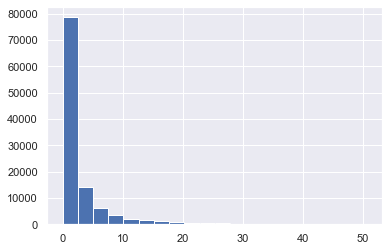

In [674]:
rmse = np.sqrt(squared_e)
z_rmse = np.abs(stats.zscore(rmse))

z_thresh = 2.8
outlier_mask = z_rmse < z_thresh



plt.hist(rmse[outlier_mask], bins=20);

In [675]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances


array([0.17083584, 0.1670507 , 0.07159515, 0.36240298, 0.09665646,
       0.03844436, 0.0930145 ])

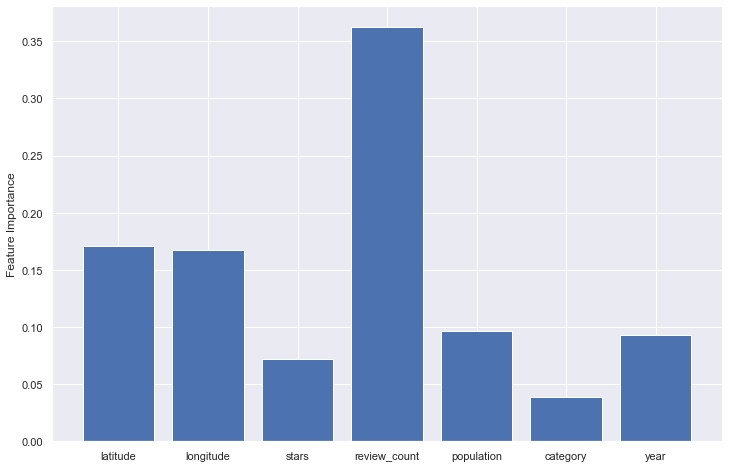

In [678]:
fig, ax = plt.subplots(figsize=(12, 8)) 


x = np.arange(len(prep_df.columns))
ax.bar(x, feature_importances)
ax.set_xticks(x)
ax.set_xticklabels(prep_df.columns);

ax.set_ylabel('Feature Importance');

Obviously the biggest surprise is how little importance category plays in the scheme of the model-- as I was expecting this to be a strong driver. As I think through the nature of the data, this actually makes sense:
* It makes sense that location would be of greater importance to the model than business category. e.g. an obscure business in downtown LA will likely have more yelp checkin's than a Starbucks in, say, Laurel MT. A way to combat this would be to make the checkin_count target variable to be computed as a function of population, which is data we have at our disposal. 
* It also makes sense that review_count would have the highest model importance. In retrospect, I should've expected this to be the field that covaries best with checkin_count. If a user is going to checkin to a business on Yelp, I would assume they are significantly more likely to leave a review while they're in the app.

# Appendix
Additional functionality for future state.

## Get BEA Data

In [ ]:
with open('secrets.json') as fh:
    keys = json.load(fh)
    yelp_api_keys = keys['yelp_api']
    bea_api_keys = keys['bea_api']

In [550]:
class BEAClient(BureauEconomicAnalysisClient):
    """
    The `pybea`package lacks a few `get` methods for specific datasets useful for this project. 
    The below wrapper class inherits functionality of `BureauEconomicAnalysisClient` with 
    added methods for missing dataset getter methods.
    
    See parent class for documentation on full class functionality.
    """
    
    def get_regional_data(self, year: List[str] = 'ALL', industry: List[str] = 'ALL', frequency: str = 'A,Q,M', 
                        table_name: List[str] = 'ALL', line_code: List[str] = 'ALL') -> Dict:
        
        """Grabs the estimates of value added, gross output, intermediate inputs, KLEMS, and employment statistics by industry.
        Arguments:
        ----
        year (List[str], optional): List of year(s) of data to retrieve (ALL for All). Defaults to 'ALL'.
        industry (List[str], optional): List of industries to retrieve (ALL for All). Defaults to 'ALL'.
        frequency (str, optional): `Q` for Quarterly data or `A` for Annual, `A,Q` for both. Defaults to 'A,Q'.
        table_id (List[str], optional): The unique GDP by Industry table identifier (ALL for All). Defaults to 'ALL'.
        Returns:
        ----
        Dict: A list of GDP figures for the industry specified.
        Example URL:
        ----
        https://apps.bea.gov/api/data/?&UserID={YOUR_API_KEY}&method=GetData&DataSetName=GDPbyIndustry&Year=2012&Industry=ALL&tableID=1&Frequency=Q&ResultFormat=JSON
        Usage:
        ----
            >>> # Initalize the new Client.
            >>> bea_client = BureauEconomicAnalysisClient(api_key=API_KEY)
            >>> # Grab GDP Data by Industry.
            >>> national_income = bea_client.gdp_by_industry(
                table_name='T10101',
                industry='ALL',
                frequency=['A', 'Q'],
                year=['2011', '2012'],
                table_id=['1']
            )
            >>> national_income
        """

        if year != 'ALL':
            year = ','.join(year)

        # Define the parameters.
        params = {
            'userid': self.api_key,
            'method': 'GetData',
            'datasetname': 'Regional',
            'year': year,
            'resultformat': self._format,
            'industry': industry,
            'frequency': frequency,
            'tablename': table_name,
            'geofips': "COUNTY",
            'linecode': line_code
        }

        # Make the request.
        response = self._make_request(
            method='get',
            params=params
        )

        return response


In [551]:
bea_client = BEAClient(bea_api_keys['api_key'])

In [552]:
test = bea_client.get_regional_data(year=['LAST5'], table_name=['CAINC1'], line_code=1)

https://apps.bea.gov/api/data/?userid=A5C27EF3-FDDB-487F-AB8F-0ACF9C6182E3&method=GetData&datasetname=Regional&year=LAST5&resultformat=JSON&industry=ALL&frequency=A%2CQ%2CM&tablename=CAINC1&geofips=COUNTY&linecode=1


In [554]:
pd.DataFrame(test['BEAAPI']['Results']['Data'])

,Code,GeoFips,GeoName,TimePeriod,CL_UNIT,UNIT_MULT,DataValue,NoteRef
0,CAINC1-1,01001,"Autauga, AL",2015,Thousands of dollars,3,"2,131,416",NaN
1,CAINC1-1,01001,"Autauga, AL",2016,Thousands of dollars,3,"2,203,281",NaN
2,CAINC1-1,01001,"Autauga, AL",2017,Thousands of dollars,3,"2,276,561",NaN
3,CAINC1-1,01001,"Autauga, AL",2018,Thousands of dollars,3,"2,360,366",NaN
4,CAINC1-1,01001,"Autauga, AL",2019,Thousands of dollars,3,"2,453,617",NaN
...,...,...,...,...,...,...,...,...
15685,CAINC1-1,56045,"Weston, WY",2015,Thousands of dollars,3,"336,749",NaN
15686,CAINC1-1,56045,"Weston, WY",2016,Thousands of dollars,3,"303,169",NaN
15687,CAINC1-1,56045,"Weston, WY",2017,Thousands of dollars,3,"296,021",NaN
15688,CAINC1-1,56045,"Weston, WY",2018,Thousands of dollars,3,"311,165",NaN


In [196]:
def get_business_data(api_key, search_term, location, limit=50):
    """
    Returns dataframe of business-level attributes given a search term
    and location.
    
    Use requires developer authentication token, see link below.
        https://www.yelp.com/login?return_url=%2Fdevelopers%2Fv3%2Fmanage_app
        
    
    example
    -----
    
    df = get_business_data(<API_KEY>, search_term = "brewery",
                           location = 'Seattle, WA')
    
    
    input
    -----
    api_key: str, 128-char API key provided by yelp
    
    search_term: str, term by which to query yelp API 
                     e.g. "gym", "brewery"
    
    location: str, or list of str, location by which to filter the search term, 
                   formatted <City, ST>
                   e.g. "Seattle, WA" or ["Seattle, WA", "Tacoma, WA"]
    
    limit: int (optional), maximum number of records to be retrieved from query
                           (cannot exceed 50)
    
    
    output
    -----
    pandas Dataframe
    
    """
    
    yelp_api = YelpAPI(api_key)
    
    if type(location) == str:
        location = [location]

    business_df = pd.DataFrame()
    
    for loc in location:
        
        try:
            response = yelp_api.search_query(term=search_term, 
                                             location=loc,
                                             limit=limit)

            df = pd.DataFrame(response['businesses'])

            business_df = business_df.append(df, ignore_index=True)
        
        except:
            return business_df
        
    return business_df
    

In [197]:
n_cities = 2500

cities = cities_df['city'] + ', ' + cities_df['state_id']
cities = list(cities)[:n_cities]
businesses_df = get_business_data(yelp_api_keys['api_key'], 'gym', cities)

In [199]:
businesses_df.to_csv('businesses.csv')

In [2]:
businesses_df = pd.read_csv('businesses.csv')

Checking for any possible duplicate entries...

In [73]:
businesses_df.sort_values('review_count', ascending=False)[:10]['name'].to_csv('business_names.csv', index=None)

In [4]:
business_ids = businesses_df['id']

print(f"Length of businesses df\t: {len(business_ids)}")
print(f"Num unique businesses\t: {len(business_ids.unique())}")

Length of businesses df	: 93293
Num unique businesses	: 42950


There are ~2 entries per business in the table. This is unsurprising, as I expect like-businesses to be returned when queried for neighboring cities (e.g. New York and New Jersey). 

In [5]:
businesses_df = businesses_df.drop_duplicates("id")

In [43]:
def get_review_data(api_key, business_id):
    
    """
    Returns dataframe of business reviews posted by yelp users.
    
    Use requires developer authentication token, see link below.
        https://www.yelp.com/login?return_url=%2Fdevelopers%2Fv3%2Fmanage_app
        
    
    example
    -----
    
    df = get_reveiew_data(<API_KEY>, ["<BID_1>","<BID_2"])
    
    
    input
    -----
    api_key: str, 128-char API key provided by yelp
    
    business_id: str or list of str, yelp ID of business entity
    
    
    output
    -----
    pandas Dataframe
    
    """
    
    yelp_api = YelpAPI(api_key)
    
    reviews = None
    
    if type(business_id) == str:
        business_id = [business_id]
    
    for bid in business_id:
        
        try:
            query = yelp_api.reviews_query(bid)
            df = pd.DataFrame(query['reviews'])

            if reviews is None:
                reviews = df

            else:
                reviews.append(df)
            
        except Exception as e:
            print(e)
            return reviews
    
    return reviews
        

In [54]:
business_ids = list(businesses_df['id'].values)
reviews_df = get_review_data(yelp_api_keys['api_key'], business_ids[:5])

In [65]:
reviews = None

for bid in [business_ids[2]]:
    
    query = yelp_api.reviews_query(bid)
    df = pd.DataFrame(query['reviews'])
    
    if reviews is None:
        reviews = df

    else:
        reviews.append(df)

In [33]:
yelp_api = YelpAPI(yelp_api_keys['api_key'])

reviews = None

for bid in business_ids[:2]:
    query = yelp_api.reviews_query(business_ids[0])
    df = pd.DataFrame(query['reviews'])
    if reviews is None:
        reviews = df
    else:
        reviews.append(df)

In [374]:
spark.sql("show tables").show()

+--------+----------+-----------+
|database| tableName|isTemporary|
+--------+----------+-----------+
|        |businesses|       true|
|        |  checkins|       true|
|        |    cities|       true|
+--------+----------+-----------+



In [87]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(df, labels)

DecisionTreeRegressor(random_state=42)

In [92]:
from sklearn.metrics import mean_squared_error

pred = tree_reg.predict(df)
tree_a= mean_squared_error(labels, pred)
tree_rmse = np.sqrt(tree_rmse)
tree_rmse

0.4870293172916887

In [93]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, df, labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [95]:
tree_rmse_scores.mean()

36.222880231967274

In [96]:
tree_rmse_scores.std()

3.30125081247333

In [97]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(df, labels)

RandomForestRegressor(random_state=42)

In [99]:
pred = forest_reg.predict(df)
forest_mse = mean_squared_error(labels, pred)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

10.28921981706641

In [100]:
forest_scores = cross_val_score(forest_reg, df, labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

KeyboardInterrupt: 

In [61]:
n_cats = 50

assembler = VectorAssembler(inputCols=features, outputCol="features")
rf = RandomForestRegressor(labelCol='label', featuresCol="features", maxBins=n_cats,
                          numTrees=50, maxDepth=25)

In [62]:
pipeline = Pipeline(stages=[assembler, rf])

In [63]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 30, num = 3)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 15, num = 3)]) \
    .build()

#     .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
#     .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \

In [64]:
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=3)

In [65]:
[int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]
[int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]

[5, 15, 25]

In [66]:
(trainingData, testData) = df.randomSplit([0.8, 0.2])

In [67]:
model = pipeline.fit(trainingData)

Py4JJavaError: An error occurred while calling o449.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 10 in stage 65.0 failed 1 times, most recent failure: Lost task 10.0 in stage 65.0 (TID 1448, localhost, executor driver): java.lang.OutOfMemoryError: GC overhead limit exceeded

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1887)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1875)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1874)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1874)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2108)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2057)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2046)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$collectAsMap$1.apply(PairRDDFunctions.scala:743)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$collectAsMap$1.apply(PairRDDFunctions.scala:742)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.PairRDDFunctions.collectAsMap(PairRDDFunctions.scala:742)
	at org.apache.spark.ml.tree.impl.RandomForest$.findBestSplits(RandomForest.scala:567)
	at org.apache.spark.ml.tree.impl.RandomForest$.run(RandomForest.scala:201)
	at org.apache.spark.ml.regression.RandomForestRegressor$$anonfun$train$1.apply(RandomForestRegressor.scala:133)
	at org.apache.spark.ml.regression.RandomForestRegressor$$anonfun$train$1.apply(RandomForestRegressor.scala:119)
	at org.apache.spark.ml.util.Instrumentation$$anonfun$11.apply(Instrumentation.scala:183)
	at scala.util.Try$.apply(Try.scala:192)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:183)
	at org.apache.spark.ml.regression.RandomForestRegressor.train(RandomForestRegressor.scala:119)
	at org.apache.spark.ml.regression.RandomForestRegressor.train(RandomForestRegressor.scala:46)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:118)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:82)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.OutOfMemoryError: GC overhead limit exceeded


----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 60825)
Traceback (most recent call last):
  File "/Users/maxcopeland/opt/anaconda3/envs/cp_env/lib/python3.7/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/Users/maxcopeland/opt/anaconda3/envs/cp_env/lib/python3.7/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/Users/maxcopeland/opt/anaconda3/envs/cp_env/lib/python3.7/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Users/maxcopeland/opt/anaconda3/envs/cp_env/lib/python3.7/socketserver.py", line 720, in __init__
    self.handle()
  File "/Users/maxcopeland/opt/anaconda3/envs/cp_env/lib/python3.7/site-packages/pyspark/accumulators.py", line 268, in handle
    poll(accum_updates)
  File "/Users/maxcopeland/opt/anaconda3/envs/cp_env/lib/python3.7

In [54]:
pred = model.transform(testData)

In [57]:
evaluator = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='rmse')

rmse = evaluator.evaluate(pred)

rfPred = model.transform(df)

rfrEsult = rfPred.toPandas()

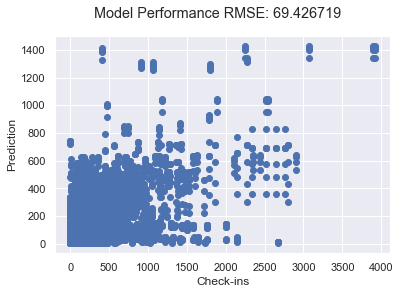

In [60]:
plt.plot(rfrEsult.label, rfrEsult.prediction, 'bo')
plt.xlabel('Check-ins')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.show()

In [65]:
# cvModel = crossval.fit(trainingData)

Py4JJavaError: An error occurred while calling o2437.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 15 in stage 130.0 failed 1 times, most recent failure: Lost task 15.0 in stage 130.0 (TID 2336, localhost, executor driver): java.lang.OutOfMemoryError: GC overhead limit exceeded
	at org.apache.spark.ml.tree.impl.DTStatsAggregator.<init>(DTStatsAggregator.scala:77)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$13$$anonfun$14.apply(RandomForest.scala:545)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$13$$anonfun$14.apply(RandomForest.scala:541)
	at scala.Array$.tabulate(Array.scala:331)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$13.apply(RandomForest.scala:541)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$13.apply(RandomForest.scala:538)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1887)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1875)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1874)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1874)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2108)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2057)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2046)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$collectAsMap$1.apply(PairRDDFunctions.scala:743)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$collectAsMap$1.apply(PairRDDFunctions.scala:742)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.PairRDDFunctions.collectAsMap(PairRDDFunctions.scala:742)
	at org.apache.spark.ml.tree.impl.RandomForest$.findBestSplits(RandomForest.scala:567)
	at org.apache.spark.ml.tree.impl.RandomForest$.run(RandomForest.scala:201)
	at org.apache.spark.ml.regression.RandomForestRegressor$$anonfun$train$1.apply(RandomForestRegressor.scala:133)
	at org.apache.spark.ml.regression.RandomForestRegressor$$anonfun$train$1.apply(RandomForestRegressor.scala:119)
	at org.apache.spark.ml.util.Instrumentation$$anonfun$11.apply(Instrumentation.scala:183)
	at scala.util.Try$.apply(Try.scala:192)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:183)
	at org.apache.spark.ml.regression.RandomForestRegressor.train(RandomForestRegressor.scala:119)
	at org.apache.spark.ml.regression.RandomForestRegressor.train(RandomForestRegressor.scala:46)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:118)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.OutOfMemoryError: GC overhead limit exceeded
	at org.apache.spark.ml.tree.impl.DTStatsAggregator.<init>(DTStatsAggregator.scala:77)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$13$$anonfun$14.apply(RandomForest.scala:545)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$13$$anonfun$14.apply(RandomForest.scala:541)
	at scala.Array$.tabulate(Array.scala:331)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$13.apply(RandomForest.scala:541)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$13.apply(RandomForest.scala:538)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 60075)
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/Users/maxcopeland/opt/anaconda3/envs/cp_env/lib/python3.7/site-packages/py4j/java_gateway.py", line 1159, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/maxcopeland/opt/anaconda3/envs/cp_env/lib/python3.7/site-packages/py4j/java_gateway.py", line 985, in send_command
    response = connection.send_command(command)
  File "/Users/maxcopeland/opt/anaconda3/envs/cp_env/lib/python3.7/site-packages/py4j/java_gateway.py", line 1164, in send_command
    "Error while receiving", e, proto.ERROR_ON_RECEIVE)
py4j.protocol.Py4JNetworkError: Error while receiving
ERROR:root:Exception while 

In [163]:
# from sklearn.preprocessing import OrdinalEncoder

# ordinal_encoder = OrdinalEncoder()
# cat_encoded = ordinal_encoder.fit_transform(df_pd['category'].values.reshape(-1, 1))
# cat_encoded

array([[ 59.],
       [225.],
       [149.],
       ...,
       [ 59.],
       [230.],
       [327.]])

In [122]:
df = spark.createDataFrame(top_cat_df)

In [123]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer

indexer = StringIndexer(inputCol="category", outputCol="category_ix")
indexer_model = indexer.fit(df_pd)
indexed = indexer_model.transform(df)

In [124]:
df = indexed.drop("category")

In [125]:
df.show()

+-------------+---------------+-----+------------+----+-----+-----------+
|     latitude|      longitude|stars|review_count|year|label|category_ix|
+-------------+---------------+-----+------------+----+-----+-----------+
|33.3628125613|    -111.908995|  3.0|          15|2018|    3|        0.0|
|    36.101321|   -115.3026032|  5.0|          37|2019|   25|        5.0|
|   33.5910441|   -111.7972384|  5.0|           7|2015|    1|        9.0|
|    33.642099|     -111.98261|  4.0|          27|2013|    6|       35.0|
|    36.145727|   -115.1903294|  3.5|          27|2018|    4|        1.0|
|    36.114583|    -115.216113|  4.5|           6|2017|    3|        7.0|
|   33.2647829|   -111.6868401|  2.5|          18|2019|    3|        1.0|
|   40.1105931|    -88.2296109|  3.0|          16|2016|    1|        0.0|
|   36.1272884|   -115.1979476|  2.5|          35|2014|   10|        0.0|
|36.0274738537|-115.0492628107|  3.5|          41|2015|   11|        3.0|
|   40.4592363|    -79.9191827|  4.0| 

In [126]:
features = [col for col in df.columns if col != 'label']

In [127]:
df_pd = df.toPandas()

The `pybea`package lacks a few `get` methods for specific datasets useful for this project. The below wrapper class inherits functionality of `BureauEconomicAnalysisClient` with added methods for missing dataset getter methods.

In [ ]:
#  'NATURALINC',
#  'INTERNATIONALMIG',
#  'DOMESTICMIG',
#  'NETMIG',
#  'RESIDUAL',
#  'GQESTIMATES',
#  'RBIRTH',
#  'RDEATH',
#  'RNATURALINC',
#  'RINTERNATIONALMIG',
#  'RDOMESTICMIG',
#  'RNETMIG',
       

In [353]:
top_n_categories = 50

categories = df_pd['category'].value_counts()[:top_n_categories].index.values
top_cat_df = df_pd[df_pd["category"].isin(categories)]
top_cat_df.shape

(331356, 8)

In [355]:
def encode_categories(categories_col, return_map=False):
    
    cat_counts = categories_col.value_counts()
    
    encoding_map = {k:v + np.random.random() for k, v in zip(cat_counts.index, cat_counts.values)}
    
    if return_map:
        return categories_col.map(encoding_map), encoding_map
    
    return categories_col.map(encoding_map)

df_pd['cat_encoded'], encoding_map = encode_categories(df_pd['category'], True)

In [121]:
df = df_pd.drop(["label", "category"], axis="columns")
labels = df_pd['label']

In [560]:
def drop_features(df, features=['business_id', 'postal_code']):
    
    return df.drop(columns=features)


def geohash(df):
    
    df['geohash'] = df.apply(lambda x: gh.encode(x['latitude'], x['longitude'], precision=3), axis=1)
    
    return df.drop(columns=['latitude', 'longitude'])


def encode_categories(df, top=50, return_map=False):
    
    cat_counts = df['category'].value_counts()[:50]
    
    encoding_map = {k:v + np.random.random() for k, v in zip(cat_counts.index, cat_counts.values)}
    
    df['category'] = df['category'].map(encoding_map).dropna(axis=0)
    
    if return_map:
        return df, encoding_map
    
    return df


prep_df = encode_categories(df)
prep_df = filter_top_cats(prep_df)
prep_df = geohash(prep_df)
prep_df = drop_features(prep_df)

labels = prep_df.label
prep_df = prep_df.drop(columns=['geohash', 'label'])

prep_df = StandardScaler().fit_transform(prep_df)

# prep_df['geohash'] = onehot_enc.transform(prep_df['geohash'].values.reshape(-1, 1))

/Users/maxcopeland/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [561]:
prep_df

array([[-0.54938596, -0.22774872, -0.84513671, -0.28615237, -0.52939504],
       [-0.54938596, -0.22774872, -0.84513671,  2.06978608, -0.52939504],
       [-0.54938596, -0.22774872, -0.84513671, -0.90676422, -0.52939504],
       ...,
       [-0.54938596,  4.19059012, -0.14680836, -0.5372224 ,  1.0385495 ],
       [-0.54938596,  4.19059012, -0.14680836, -0.79147862,  1.0385495 ],
       [-0.54938596,  4.19059012, -0.14680836,  2.06978608,  1.0385495 ]])

In [557]:
class EncodeCategories(BaseEstimator, TransformerMixin):
    
    """
    Custom transformer to numerically encode categories
    """
        
    def __init__(self, n_cat=50):
        self.n_cat = n_cat
    
    
    def fit(self, X, y=None):
        
        cat_counts = X['category'].value_counts()[:self.n_cat]
        encoding_map = {k:v + np.random.random() for k, v in zip(cat_counts.index, cat_counts.values)}
        
        self.encoding_map = encoding_map
            
        return self
    
    
    def transform(self, X):
        
        mapped_cats = X['category'].map(self.encoding_map).values

        X['category'] = mapped_cats
        
        return X
    

class EncodeCoordinates(BaseEstimator, TransformerMixin):
    
    """
    Custom transformer to encode latitude, longitude
    """
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):

        X['geohash'] = X.apply(lambda x: gh.encode(x['latitude'], x['longitude'], precision=3), axis=1)

        return X

Creating pipeline for necessary transformations.

In [513]:
pipe = Pipeline([('cat_encoder', EncodeCategories(n_cat=50)), 
                 ('coord_encoder', EncodeCoordinates()), 
                 ('std_scaler', StandardScaler())])

In [514]:

test = df.copy().drop(columns=['business_id', 'postal_code'])
test = test.drop(columns='label')

d = pipe.fit_transform(test)

ValueError: could not convert string to float: 'dpp'

In [494]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

numerical_features = ['stars', 'review_count','year','population']
cat_feature = ['category']
coords_features = ['latitude', 'longitude']
geohash_feature = ['geohash']

In [517]:
full_pipe = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ("cat", EncodeCategories(), cat_feature),
    ("onehot", OneHotEncoder(), geohash_feature),
])

In [523]:
test = prep_df.copy()

d = full_pipe.fit_transform(test)

In [533]:
d

array([[-0.54938596, -0.22774872, -0.52939504, ...,  0.        ,
         1.        ,  0.        ],
       [-0.54938596, -0.22774872, -0.52939504, ...,  0.        ,
         1.        ,  0.        ],
       [-0.54938596, -0.22774872, -0.52939504, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.54938596,  4.19059012,  1.0385495 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.54938596,  4.19059012,  1.0385495 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.54938596,  4.19059012,  1.0385495 , ...,  0.        ,
         0.        ,  0.        ]])

In [528]:
labels

,latitude,longitude,stars,review_count,postal_code,population,category,year
0,40.427522,-79.967984,3.5,26,15203,1233027,Hair Removal,2014
1,40.427522,-79.967984,3.5,26,15203,1233027,Beauty & Spas,2014
2,40.427522,-79.967984,3.5,26,15203,1233027,Ophthalmologists,2014
3,40.427522,-79.967984,3.5,26,15203,1233027,Cosmetic Surgeons,2014
4,40.427522,-79.967984,3.5,26,15203,1233027,Laser Hair Removal,2014
...,...,...,...,...,...,...,...,...
450537,36.167190,-115.285593,3.5,34,89145,2226115,Fitness & Instruction,2018
450538,36.167190,-115.285593,3.5,34,89145,2226115,Party & Event Planning,2018
450539,36.167190,-115.285593,3.5,34,89145,2226115,Preschools,2018
450540,36.167190,-115.285593,3.5,34,89145,2226115,Event Planning & Services,2018


In [535]:
prep_df

,stars,review_count,population,category,year,geohash
0,3.5,26,1233027,Hair Removal,2014,dpp
1,3.5,26,1233027,Beauty & Spas,2014,dpp
4,3.5,26,1233027,Laser Hair Removal,2014,dpp
5,3.5,26,1233027,Doctors,2014,dpp
7,3.5,26,1233027,Health & Medical,2014,dpp
...,...,...,...,...,...,...
450543,3.5,443,2226115,Event Planning & Services,2018,9qq
450544,3.5,443,2226115,Day Spas,2018,9qq
450547,3.5,443,2226115,Venues & Event Spaces,2018,9qq
450548,3.5,443,2226115,Hotels,2018,9qq


In [534]:
pd.DataFrame(d)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-0.549386,-0.227749,-0.529395,-0.845137,15625.451170,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.549386,-0.227749,-0.529395,-0.845137,67798.283783,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.549386,-0.227749,-0.529395,-0.845137,1882.715959,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.549386,-0.227749,-0.529395,-0.845137,5190.516720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.549386,-0.227749,-0.529395,-0.845137,16135.959409,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388484,-0.549386,4.190590,1.038550,-0.146808,11474.893131,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
388485,-0.549386,4.190590,1.038550,-0.146808,11988.066948,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
388486,-0.549386,4.190590,1.038550,-0.146808,10065.009293,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
388487,-0.549386,4.190590,1.038550,-0.146808,4435.824613,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
